##Generate video using simulated pose and expression BUPT 480 image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) # My Drive
# Change to your local path if needed
import os
path = '/content/gdrive/.shortcut-targets-by-id/1Kv4V2PfcDb3WIGdtBo48x6lRiYbsR3GM/Biofacenet_n/DECA/DECA'
os.chdir(path)

Mounted at /content/gdrive


In [3]:
!nvidia-smi

Fri Apr  1 00:40:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !cp -r ./../../PPB_all /content/

In [4]:
!cp ./../bupt_balanced_480.zip -d /content/
!unzip /content/bupt_balanced_480.zip -d /content/

Archive:  /content/bupt_balanced_480.zip
   creating: /content/bupt_balanced_480/
  inflating: /content/bupt_balanced_480/Indianm0jl05tmc_1.jpg  
  inflating: /content/bupt_balanced_480/Indianm0546q9000042_00@en.jpg  
  inflating: /content/bupt_balanced_480/Africanm059_rzq2-FaceId-0_align.jpg  
  inflating: /content/bupt_balanced_480/Indianm027b3l9000063_00@en.jpg  
  inflating: /content/bupt_balanced_480/Africanm0h_j5wm112-FaceId-0_align.jpg  
  inflating: /content/bupt_balanced_480/Africanm0clcqv102-FaceId-0_align.jpg  
  inflating: /content/bupt_balanced_480/Asianm0nccxf6000077_00@ja.jpg  
  inflating: /content/bupt_balanced_480/Caucasianm04nxfq11-FaceId-0_align.jpg  
  inflating: /content/bupt_balanced_480/Indianm02q9tgl000000_00@en.jpg  
  inflating: /content/bupt_balanced_480/Africanm023vbq62-FaceId-0_align.jpg  
  inflating: /content/bupt_balanced_480/Caucasianm0d2zzh62-FaceId-0_align.jpg  
  inflating: /content/bupt_balanced_480/Caucasianm01lpl7c11-FaceId-0_align.jpg  
  inflat

In [5]:
# !ls /content/PPB_dataset/F1

In [ ]:
!pip install -r requirements.txt

In [7]:
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-6c3b89zq
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-6c3b89zq
     |████████████████████████████████| 50 kB 2.3 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.1-cp37-cp37m-linux_x86_64.whl size=24941873 sha256=4b75f68a6d938dd1835dce44601cacbb3bea61f72e75cf5199b679fe2141e82d
  Stored in directory: /tmp/pip-ephem-wheel-cache-w1l5g7ey/wheels/db/2f/07/b84807ee4c9ffc917b90b716977d7fea8f9e841f6173150600
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220305-py3-none-any.whl size=61214 sha256=b312c8c8ea8e13f986768c05ee7b71fc8df446873ba82fb8ce6e0b3aaae2c495
  Stored in directory: /root/.cache/pip/wheels/b5/b7/6e/43b1693d06fac3633af48db68557513b0a37ab38b0a8b798f9
Successfully built pytorch3d fvcore
ERROR: For req: pytorch3d==0.6.1. Invalid script entry point: <ExportEntry pytorch3d_implicitron_runner = projects.implicitron_trainer.experim

# Library

In [8]:
import time, os, sys, math
import cv2
import numpy as np
from time import time
from scipy.io import savemat
import argparse
import imageio
from skimage.transform import rescale
import torch
import matplotlib.pyplot as plt
import h5py 
from pathlib import Path
import pandas as pd 
from glob import glob
import random


# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.rotation_converter import batch_euler2axis, deg2rad
from decalib.utils.config import cfg as deca_cfg

import os, sys
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
from time import time
from skimage.io import imread
import cv2
import pickle
sys.path.insert(0, os.path.join(os.getcwd(), 'decalib'))

from utils.renderer import SRenderY_modified

# #from utils.renderer import SRenderY

from models.encoders import ResnetEncoder
from models.FLAME import FLAME, FLAMETex
from models.decoders import Generator
from utils import util
from utils.rotation_converter import batch_euler2axis
from datasets import datasets
from utils.config import cfg

torch.backends.cudnn.benchmark = True

import scipy.io as io
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import Dataset, TensorDataset
import torchvision.transforms as transforms

import argparse
from matplotlib import cm
from sklearn.decomposition import PCA

# Helper

In [9]:
def show_img(img):
  plt.imshow(img)
  plt.show()

def show_img_final(img, savename):
  plt.imshow(img)
  plt.axis('off')
  plt.savefig(savename, bbox_inches='tight')
  plt.show()

# DECA 

In [10]:
class DECA(object):
    def __init__(self, config=None, device='cuda'):
        if config is None:
            self.cfg = cfg
        else:
            self.cfg = config
        self.device = device
        self.image_size = self.cfg.dataset.image_size
        self.uv_size = self.cfg.model.uv_size

        self._create_model(self.cfg.model)
        self._setup_renderer(self.cfg.model)

    def _setup_renderer(self, model_cfg):
        # self.render = SRenderY(self.image_size, obj_filename=model_cfg.topology_path, uv_size=model_cfg.uv_size).to(self.device)
        self.render = SRenderY_modified(self.image_size, obj_filename=model_cfg.topology_path, uv_size=model_cfg.uv_size).to(self.device)
        # face mask for rendering details
        mask = imread(model_cfg.face_eye_mask_path).astype(np.float32)/255.; mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
        self.uv_face_eye_mask = F.interpolate(mask, [model_cfg.uv_size, model_cfg.uv_size]).to(self.device)
        mask = imread(model_cfg.face_mask_path).astype(np.float32)/255.; mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
        self.uv_face_mask = F.interpolate(mask, [model_cfg.uv_size, model_cfg.uv_size]).to(self.device)
        # displacement correction
        fixed_dis = np.load(model_cfg.fixed_displacement_path)
        self.fixed_uv_dis = torch.tensor(fixed_dis).float().to(self.device)
        # mean texture
        mean_texture = imread(model_cfg.mean_tex_path).astype(np.float32)/255.; mean_texture = torch.from_numpy(mean_texture.transpose(2,0,1))[None,:,:,:].contiguous()
        self.mean_texture = F.interpolate(mean_texture, [model_cfg.uv_size, model_cfg.uv_size]).to(self.device)
        # dense mesh template, for save detail mesh
        self.dense_template = np.load(model_cfg.dense_template_path, allow_pickle=True, encoding='latin1').item()

    def _create_model(self, model_cfg):
        # set up parameters
        self.n_param = model_cfg.n_shape+model_cfg.n_tex+model_cfg.n_exp+model_cfg.n_pose+model_cfg.n_cam+model_cfg.n_light
        self.n_detail = model_cfg.n_detail
        self.n_cond = model_cfg.n_exp + 3 # exp + jaw pose
        self.num_list = [model_cfg.n_shape, model_cfg.n_tex, model_cfg.n_exp, model_cfg.n_pose, model_cfg.n_cam, model_cfg.n_light]
        self.param_dict = {i:model_cfg.get('n_' + i) for i in model_cfg.param_list}

        # encoders
        self.E_flame = ResnetEncoder(outsize=self.n_param).to(self.device) 
        self.E_detail = ResnetEncoder(outsize=self.n_detail).to(self.device)
        # decoders
        self.flame = FLAME(model_cfg).to(self.device)
        if model_cfg.use_tex:
            self.flametex = FLAMETex(model_cfg).to(self.device)
        self.D_detail = Generator(latent_dim=self.n_detail+self.n_cond, out_channels=1, out_scale=model_cfg.max_z, sample_mode = 'bilinear').to(self.device)
        # resume model
        model_path = self.cfg.pretrained_modelpath
        if os.path.exists(model_path):
            print(f'trained model found. load {model_path}')
            checkpoint = torch.load(model_path)
            self.checkpoint = checkpoint
            util.copy_state_dict(self.E_flame.state_dict(), checkpoint['E_flame'])
            util.copy_state_dict(self.E_detail.state_dict(), checkpoint['E_detail'])
            util.copy_state_dict(self.D_detail.state_dict(), checkpoint['D_detail'])
        else:
            print(f'please check model path: {model_path}')
            exit()
        # eval mode
        self.E_flame.eval()
        self.E_detail.eval()
        self.D_detail.eval()

    def decompose_code(self, code, num_dict):
        ''' Convert a flattened parameter vector to a dictionary of parameters
        code_dict.keys() = ['shape', 'tex', 'exp', 'pose', 'cam', 'light']
        '''
        code_dict = {}
        start = 0
        for key in num_dict:
            end = start+int(num_dict[key])
            code_dict[key] = code[:, start:end]
            start = end
            if key == 'light':
                code_dict[key] = code_dict[key].reshape(code_dict[key].shape[0], 9, 3)
        return code_dict

    def displacement2normal(self, uv_z, coarse_verts, coarse_normals):
        ''' Convert displacement map into detail normal map
        '''
        batch_size = uv_z.shape[0]
        uv_coarse_vertices = self.render.world2uv(coarse_verts).detach()
        uv_coarse_normals = self.render.world2uv(coarse_normals).detach()
    
        uv_z = uv_z*self.uv_face_eye_mask
        uv_detail_vertices = uv_coarse_vertices + uv_z*uv_coarse_normals + self.fixed_uv_dis[None,None,:,:]*uv_coarse_normals.detach()
        dense_vertices = uv_detail_vertices.permute(0,2,3,1).reshape([batch_size, -1, 3])
        uv_detail_normals = util.vertex_normals(dense_vertices, self.render.dense_faces.expand(batch_size, -1, -1))
        uv_detail_normals = uv_detail_normals.reshape([batch_size, uv_coarse_vertices.shape[2], uv_coarse_vertices.shape[3], 3]).permute(0,3,1,2)
        return uv_detail_normals

    def displacement2vertex(self, uv_z, coarse_verts, coarse_normals):
        ''' Convert displacement map into detail vertices
        '''
        batch_size = uv_z.shape[0]
        uv_coarse_vertices = self.render.world2uv(coarse_verts).detach()
        uv_coarse_normals = self.render.world2uv(coarse_normals).detach()
    
        uv_z = uv_z*self.uv_face_eye_mask
        uv_detail_vertices = uv_coarse_vertices + uv_z*uv_coarse_normals + self.fixed_uv_dis[None,None,:,:]*uv_coarse_normals.detach()
        dense_vertices = uv_detail_vertices.permute(0,2,3,1).reshape([batch_size, -1, 3])
        # uv_detail_normals = util.vertex_normals(dense_vertices, self.render.dense_faces.expand(batch_size, -1, -1))
        # uv_detail_normals = uv_detail_normals.reshape([batch_size, uv_coarse_vertices.shape[2], uv_coarse_vertices.shape[3], 3]).permute(0,3,1,2)
        detail_faces =  self.render.dense_faces
        return dense_vertices, detail_faces

    def visofp(self, normals):
        ''' visibility of keypoints, based on the normal direction
        '''
        normals68 = self.flame.seletec_3d68(normals)
        vis68 = (normals68[:,:,2:] < 0.1).float()
        return vis68

    @torch.no_grad()
    def encode(self, images):
        batch_size = images.shape[0]
        parameters = self.E_flame(images)
        detailcode = self.E_detail(images)
        codedict = self.decompose_code(parameters, self.param_dict)
        codedict['detail'] = detailcode
        codedict['images'] = images
        return codedict

    @torch.no_grad()
    def decode(self, codedict):
        images = codedict['images']
        batch_size = images.shape[0]
        
        ## decode
        verts, landmarks2d, landmarks3d = self.flame(shape_params=codedict['shape'], expression_params=codedict['exp'], pose_params=codedict['pose'])
        uv_z = self.D_detail(torch.cat([codedict['pose'][:,3:], codedict['exp'], codedict['detail']], dim=1))
        if self.cfg.model.use_tex:
            albedo = self.flametex(codedict['tex'])
        else:
            albedo = torch.zeros([batch_size, 3, self.uv_size, self.uv_size], device=images.device) 
        ## projection
        landmarks2d = util.batch_orth_proj(landmarks2d, codedict['cam'])[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
        landmarks3d = util.batch_orth_proj(landmarks3d, codedict['cam']); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:]; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
        trans_verts = util.batch_orth_proj(verts, codedict['cam']); trans_verts[:,:,1:] = -trans_verts[:,:,1:]
        
        ## rendering
        ops = self.render(verts, trans_verts, albedo, codedict['light'])
        uv_detail_normals = self.displacement2normal(uv_z, verts, ops['normals'])
        uv_shading = self.render.add_SHlight(uv_detail_normals, codedict['light'])
        uv_texture = albedo*uv_shading

        landmarks3d_vis = self.visofp(ops['transformed_normals'])
        landmarks3d = torch.cat([landmarks3d, landmarks3d_vis], dim=2)

        ## render shape
        shape_images = self.render.render_shape(verts, trans_verts, images=ops['albedo_images'], lights=codedict['light'])
        # shape_images = self.render.render_shape(verts, trans_verts)

        detail_normal_images = F.grid_sample(uv_detail_normals, ops['grid'], align_corners=False)*ops['alpha_images']
        # shape_detail_images = self.render.render_shape(verts, trans_verts, detail_normal_images=detail_normal_images)
        shape_detail_images = self.render.render_shape(verts, trans_verts, images=ops['albedo_images'], detail_normal_images=detail_normal_images, lights=codedict['light'])
        
        ## extract texture
        ## TODO: current resolution 256x256, support higher resolution, and add visibility
        uv_pverts = self.render.world2uv(trans_verts)
        uv_gt = F.grid_sample(images, uv_pverts.permute(0,2,3,1)[:,:,:,:2], mode='bilinear')
        if self.cfg.model.use_tex:
            ## TODO: poisson blending should give better-looking results
            uv_texture_gt = uv_gt[:,:3,:,:]*self.uv_face_eye_mask + (uv_texture[:,:3,:,:]*(1-self.uv_face_eye_mask)*0.7)
        else:
            uv_texture_gt = uv_gt[:,:3,:,:]*self.uv_face_eye_mask + (torch.ones_like(uv_gt[:,:3,:,:])*(1-self.uv_face_eye_mask)*0.7)
            
        ## output
        opdict = {
            'vertices': verts,
            'normals': ops['normals'],
            'transformed_vertices': trans_verts,
            'landmarks2d': landmarks2d,
            'landmarks3d': landmarks3d,
            'uv_detail_normals': uv_detail_normals,
            'uv_texture_gt': uv_texture_gt,
            'displacement_map': uv_z+self.fixed_uv_dis[None,None,:,:],
        }
        if self.cfg.model.use_tex:
            opdict['albedo'] = albedo
            opdict['uv_texture'] = uv_texture

        visdict = {
            'inputs': images, 
            'landmarks2d': util.tensor_vis_landmarks(images, landmarks2d, isScale=False),
            'landmarks3d': util.tensor_vis_landmarks(images, landmarks3d, isScale=False),
            'shape_images': shape_images,
            'shape_detail_images': shape_detail_images,
            'uv_texture': uv_texture,
            'uv_texture_gt': uv_gt[:,:3,:,:]*self.uv_face_eye_mask,
            'uv_gt': uv_gt,
            'albedo': albedo
        }
        if self.cfg.model.use_tex:
            visdict['rendered_images'] = ops['images']
        return opdict, visdict
    
    @torch.no_grad()
    def decode_modified(self, codedict, albedo):
        images = codedict['images']
        batch_size = images.shape[0]
        
        ## decode
        verts, landmarks2d, landmarks3d = self.flame(shape_params=codedict['shape'], expression_params=codedict['exp'], pose_params=codedict['pose'])
        uv_z = self.D_detail(torch.cat([codedict['pose'][:,3:], codedict['exp'], codedict['detail']], dim=1))
       
        ## projection
        landmarks2d = util.batch_orth_proj(landmarks2d, codedict['cam'])[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
        landmarks3d = util.batch_orth_proj(landmarks3d, codedict['cam']); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:]; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
        trans_verts = util.batch_orth_proj(verts, codedict['cam']); trans_verts[:,:,1:] = -trans_verts[:,:,1:]
        
        ## rendering
        ops = self.render(verts, trans_verts, albedo, codedict['light'])
        uv_detail_normals = self.displacement2normal(uv_z, verts, ops['normals'])
        uv_shading = self.render.add_SHlight(uv_detail_normals, codedict['light'])
        uv_texture = albedo*uv_shading

        landmarks3d_vis = self.visofp(ops['transformed_normals'])
        landmarks3d = torch.cat([landmarks3d, landmarks3d_vis], dim=2)

        ## render shape
        shape_images = self.render.render_shape(verts, trans_verts, images=ops['albedo_images'], lights=codedict['light'])
        # shape_images = self.render.render_shape(verts, trans_verts)

        detail_normal_images = F.grid_sample(uv_detail_normals, ops['grid'], align_corners=False)*ops['alpha_images']
        shape_detail_images = self.render.render_shape(verts, trans_verts, images=ops['albedo_images'], detail_normal_images=detail_normal_images, lights=codedict['light'])
        # shape_detail_images = self.render.render_shape(verts, trans_verts, detail_normal_images=detail_normal_images)
        
        ## extract texture
        ## TODO: current resolution 256x256, support higher resolution, and add visibility
        uv_pverts = self.render.world2uv(trans_verts)
        uv_gt = F.grid_sample(images, uv_pverts.permute(0,2,3,1)[:,:,:,:2], mode='bilinear')
        if self.cfg.model.use_tex:
            ## TODO: poisson blending should give better-looking results
            uv_texture_gt = uv_gt[:,:3,:,:]*self.uv_face_eye_mask + (uv_texture[:,:3,:,:]*(1-self.uv_face_eye_mask)*0.7)
        else:
            uv_texture_gt = uv_gt[:,:3,:,:]*self.uv_face_eye_mask + (torch.ones_like(uv_gt[:,:3,:,:])*(1-self.uv_face_eye_mask)*0.7)
            
        ## output
        opdict = {
            'vertices': verts,
            'normals': ops['normals'],
            'transformed_vertices': trans_verts,
            'landmarks2d': landmarks2d,
            'landmarks3d': landmarks3d,
            'uv_detail_normals': uv_detail_normals,
            'uv_texture_gt': uv_texture_gt,
            'displacement_map': uv_z+self.fixed_uv_dis[None,None,:,:],
        }
        if self.cfg.model.use_tex:
            opdict['albedo'] = albedo
            opdict['uv_texture'] = uv_texture

        visdict = {
            'inputs': images, 
            'landmarks2d': util.tensor_vis_landmarks(images, landmarks2d, isScale=False),
            'landmarks3d': util.tensor_vis_landmarks(images, landmarks3d, isScale=False),
            'shape_images': shape_images,
            'shape_detail_images': shape_detail_images,
            'uv_texture': uv_texture,
            'uv_texture_gt': uv_gt[:,:3,:,:]*self.uv_face_eye_mask,
            'uv_gt': uv_gt,
            'albedo': albedo,
            'albedo_image': ops['albedo_images'],
            'detail_normal_images': detail_normal_images
        }
        if self.cfg.model.use_tex:
            visdict['rendered_images'] = ops['images']
        return opdict, visdict

    def visualize(self, visdict, size=None):
        grids = {}
        if size is None:
            size = self.image_size
        for key in visdict:
            grids[key] = torchvision.utils.make_grid(F.interpolate(visdict[key], [size, size])).detach().cpu()
        grid = torch.cat(list(grids.values()), 2)
        grid_image = (grid.numpy().transpose(1,2,0).copy()*255)[:,:,[2,1,0]]
        grid_image = np.minimum(np.maximum(grid_image, 0), 255).astype(np.uint8)
        return grid_image
    
    def save_obj(self, filename, opdict):
        '''
        vertices: [nv, 3], tensor
        texture: [3, h, w], tensor
        '''
        i = 0
        vertices = opdict['vertices'][i].cpu().numpy()
        faces = self.render.faces[0].cpu().numpy()
        texture = util.tensor2image(opdict['uv_texture_gt'][i])
        uvcoords = self.render.raw_uvcoords[0].cpu().numpy()
        uvfaces = self.render.uvfaces[0].cpu().numpy()
        # save coarse mesh, with texture and normal map
        normal_map = util.tensor2image(opdict['uv_detail_normals'][i]*0.5 + 0.5)
        util.write_obj(filename, vertices, faces, 
                        texture=texture, 
                        uvcoords=uvcoords, 
                        uvfaces=uvfaces, 
                        normal_map=normal_map)
        # upsample mesh, save detailed mesh
        texture = texture[:,:,[2,1,0]]
        normals = opdict['normals'][i].cpu().numpy()
        displacement_map = opdict['displacement_map'][i].cpu().numpy().squeeze()
        dense_vertices, dense_colors, dense_faces = util.upsample_mesh(vertices, normals, faces, displacement_map, texture, self.dense_template)
        util.write_obj(filename.replace('.obj', '_detail.obj'), 
                        dense_vertices, 
                        dense_faces,
                        colors = dense_colors,
                        inverse_face_order=True)

# Biofacenet

In [11]:
def scalingNet(lightingparameters,b,fmel,fblood,Shading,specmask,bSize=2):
  '''
  Inputs:
      lightingparameters              :   [N,15]
      b                               :   [N,2]  
      fmel,fblood,Shading,specmask    :   [N,H,W]
  Outputs:
      weightA, weightD                :   [N]
      CCT                             :   [N]
      Fweights                        :   [N,12]
      b, BGrid                        :   [N,2]  
      fmel,fblood,Shading,specmask    :   [N,H,W]
  '''
  lightingweights = F.softmax(lightingparameters[:,0:14],1) # [N,14]
  weightA = lightingweights[:,0] # [N]
  weightD = lightingweights[:,1]
  Fweights = lightingweights[:,2:14] # [N,12]
  CCT = lightingparameters[:,14] # [N]
  CCT = (21/(1 + torch.exp(-CCT))) # scale [0-21] since 0 indexing
  
  b = 6*torch.sigmoid(b) - 3 # Remove range constraint
  BGrid =  b/3.0  #

  # fmel = 2*torch.sigmoid(fmel)-1 # Remove range constraint
  # fblood = 2*torch.sigmoid(fblood)-1 # Remove range constraint
  # fblood = (torch.tanh(fblood) + 1) / 40 + 0.02 # 0.02 - 0.07
  # fmel = (torch.tanh(fmel) + 1) / 4 # 0 - 0.5
  fblood = torch.tanh(fblood)
  fmel = torch.tanh(fmel)

  Shading = torch.exp(Shading)
  specmask = torch.exp(specmask)

  return weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,Shading,specmask


def cameraModel_modified(mu,PC,rgbCMF,b,wavelength):
    '''
    Inputs:
        mu         :  [99,1]
        PC         :  [99,2]
        b          :  [N,2] 
    Outputs:
        Sr,Sg,Sb   :  [N,33]
    '''
    N = b.shape[1]
    # PCA model
    S = mu + torch.matmul(PC,b.T)  # [99,N]
    S =  F.relu(S) 
    
    Sr = S[0:wavelength].permute(1,0)  # [33,N] -> [N,33]           
    Sg = S[wavelength:wavelength*2].permute(1,0)
    Sb = S[wavelength*2:wavelength*3].permute(1,0)

    # S = rgbCMF
    # Sr = S[0, 0].unsqueeze(0).repeat(b.shape[0], 1)  # [33,N] -> [N,33]           
    # Sg = S[0, 1].unsqueeze(0).repeat(b.shape[0], 1)
    # Sb = S[0, 2].unsqueeze(0).repeat(b.shape[0], 1)
    # print(S[0, 0])
    return Sr,Sg, Sb

def illuminationModel_modified(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm):
    '''
    Inputs:
        weightA, weightD                :   [N]
        Fweights                        :   [N,12]
        CCT                             :   [N]
        illumA                          :   [33]
        illumDNorm                      :   [33,22]
        illumFNorm                      :   [33,12]
    Output:
        e                               :   [N,33]
    '''
    N = weightA.numel()
    
# illumination A:
    illuminantA = weightA.view(-1,1)*illumA.view(1,-1) # [N,33] = [N,1]*[1,33]
    # illuminantA = illumA.view(1,-1).repeat(N, 1) # using constant illuminant for all images
    # print(illumA)

# illumination D:
    illumDNorm = illumDNorm.view(1,1,33,22)
    grid = torch.zeros(N,1,33,2).to(illumDNorm.device)
    grid[:,0,:,0] = (2*CCT/21-1).view(N,1)
    grid[:,0,:,1]=torch.tensor([-1+i*(2/32) for i in range(33)]) # [N,33] <- [33]
    illumD = F.grid_sample(illumDNorm.expand(N,-1,-1,-1), grid, align_corners=True).squeeze() # [N,1,1,33] -> [N,33]
    illuminantD = weightD.view(-1,1) * illumD # [N,33] = [N,1] * [N,33]

# illumination F:
    illumFNorm = illumFNorm.view(33,12,1)
    Fweights = Fweights.permute(1,0) # [12,N]
    illuminantF = illumFNorm*Fweights 
    illuminantF = illuminantF.sum(1).permute(1,0) # [33,12,N] -> [33,N] -> [N,33]

    e = illuminantA + illuminantD + illuminantF 
    e = e/e.sum(1, keepdim=True)

    return e


def computelightcolour(e,Sr,Sg,Sb):
  '''
  Inputs:
      Sr,Sg,Sb         : [N,33]
      e                : [N,33]
  Output:
      lightcolour      : [N,3]
  '''
  lightcolour = torch.stack([(Sr*e).sum(1), (Sg*e).sum(1), (Sb*e).sum(1)],1)
  # print('light color', lightcolour[0])
  return lightcolour


def computeSpecularities(specmask,lightcolour):
  '''
  Inputs:
      specmask         : [N,H,W]
      lightcolour      : [N,3]
  Output:
      Specularities    : [N,3,H,W]
  '''
  specmask = specmask.unsqueeze(1) # [N,1,H,W]
  Specularities = specmask*lightcolour.view(-1,3,1,1) # [N,3,H ,W] = [N,1,H,W ] * [N,3,1,1]

  return Specularities


def BiotoSpectralRef(fmel,fblood,Newskincolour):
  '''
  Inputs:
      fmel,fblood      : [N,H,W]
      Newskincolour    : [1,33,256,256]
  Output:
      R_total          : [N,33,H,W]
  '''
  N = fmel.shape[0]
  BiophysicalMaps =   torch.cat([fmel.unsqueeze(1),fblood.unsqueeze(1)], dim=1) # [N,2,H,W]   
  BiophysicalMaps =   BiophysicalMaps.permute(0,2,3,1)  # [N,H,W,2], grid
  Newskincolour = Newskincolour.expand(N,-1,-1,-1) # [N,33,256,256]
  R_total  = F.grid_sample(Newskincolour, BiophysicalMaps, align_corners=True)
  # print(R_total.shape)
  # R_total = Newskincolour
  return R_total


def ImageFormation (R_total, Sr,Sg,Sb,e,Specularities,Shading):
  '''
  Inputs:
      R_total          : [N,33,H,W]
      Sr,Sg,Sb,e       : [N,33]
      Specularities    : [N,3,H,W]
      Shading          : [N,H,W]
  Output:
      rawAppearance, diffuseAlbedo : [N,3,H,W]
  ''' 
  # N = e.shape[0]
  e = e * 3
  spectraRef = R_total*e.view(-1,33,1,1) # N x 33 x H x W
  rChannel = (spectraRef*Sr.view(-1,33,1,1)).sum(1,keepdim=True)
  # print('rChannel', rChannel[0])
  gChannel = (spectraRef*Sg.view(-1,33,1,1)).sum(1,keepdim=True)
  bChannel = (spectraRef*Sb.view(-1,33,1,1)).sum(1,keepdim=True) # [N,1,H,W]

  diffuseAlbedo = torch.cat([rChannel,gChannel,bChannel], dim=1) # [N,3,H,W]
  ShadedDiffuse = diffuseAlbedo*(Shading.unsqueeze(1)) # [N,3,H,W] = [N,3,H,W] * [N,1,H,W]
  rawAppearance = ShadedDiffuse + Specularities

  return rawAppearance, diffuseAlbedo


def WhiteBalance(rawAppearance,lightcolour):
  '''
  Inputs:
      rawAppearance    : [N,3,H,W]
      lightcolour      : [N,3]
  Output:
      ImwhiteBalanced  : [N,3,H,W]
  '''
  ImwhiteBalanced = rawAppearance/lightcolour.view(-1,3,1,1) # [N,3,H,W] = [N,3,H,W] / [N,3,1,1]

  return ImwhiteBalanced


def findT(Tmatrix,BGrid):
  '''
  Inputs:
      Tmatrix          : [1,9,128,128]
      BGrid            : [N,2]
  Output:
      T_RAW2XYZ        : [N,9]
  '''
  N = BGrid.shape[0]
  T_RAW2XYZ = F.grid_sample(Tmatrix.expand(N,-1,-1,-1), BGrid.view(N,1,1,2), align_corners=True).squeeze() # [N,9,1,1] -> [N,9]
  # T_RAW2XYZ = torch.tensor([0.2656, 0.1325, 0.0314, 0.0064, 0.2475, -0.1098, 0.0533, -0.0374, 0.4507]).to(device)
  # T_RAW2XYZ = T_RAW2XYZ.expand(N, -1)

  return T_RAW2XYZ


def fromRawTosRGB(imWB,T_RAW2XYZ,Txyzrgb):
  '''
  Inputs:
      imWB             : [N,3,H,W]
      T_RAW2XYZ        : [N,9]
      Txyzrgb          : [N,9]
  Output:
      T_RAW2XYZ        : [N,9]
  '''
  T_R2X = T_RAW2XYZ.view(-1,3,3,1,1) # [[1,2,3],[4,5,6],[7,8,9]]
  Ix = (T_R2X[:,:,0] * imWB).sum(1) # [N,3,1,1] * [N,3,H,W] -> [N,3,H,W] -> [N,H,W]
  Iy = (T_R2X[:,:,1] * imWB).sum(1)
  Iz = (T_R2X[:,:,2] * imWB).sum(1)

  Ixyz = torch.stack([Ix,Iy,Iz],1) # [N,3,H,W]

  R = (Txyzrgb[0,:].view(-1,1,1) * Ixyz).sum(1) # [3,1,1] * [N,3,H,W] -> [N,3,H,W] -> [N,H,W]
  G = (Txyzrgb[1,:].view(-1,1,1) * Ixyz).sum(1)
  B = (Txyzrgb[2,:].view(-1,1,1) * Ixyz).sum(1)

  sRGBim = torch.stack([R,G,B],1) # [N,3,H,W]
  sRGBim =F.relu(sRGBim)

  return sRGBim


def priorLoss(b, weight):
  loss = (b*b).sum()
  return loss*weight


def appearanceLoss(rgbim, images, muim, weight):
  rgb = rgbim - muim.view(-1,1,1)
  delta = images - rgb
  loss = (delta*delta).sum()
  return loss*weight


def sparsityLoss(Specularities, weight):
  #L1 sparsity loss
  loss = Specularities.sum()
  return loss*weight


def shadingLoss(actualshading, predictedShading, actualmasks, weight):
  '''
  Inputs:
      actualshading, predictedShading : [N,H,W]
      actualmasks                     : [N,H,W] 
  '''
  scale = ((actualshading*predictedShading)*actualmasks).sum(2).sum(1)/((predictedShading**2)*actualmasks).sum(2).sum(1)  # [N]

  predictedShading = predictedShading*scale.view(-1,1,1)
  alpha = (actualshading - predictedShading)*actualmasks
  loss = (alpha**2).sum()
  return loss*weight

def cstretch(img, a=0., b=1.):
  '''
  contrast stretch numpy image
  '''
  if len(img.shape) == 2:
    c = np.min(img)
    d = np.max(img)
    img=(img-c)/(d-c)*(b-a) + a
    return img
  for i in range(3):
    img[:,:,i]=cstretch(img[:,:,i],a,b)
  return img

  '''
class to load util data
'''
class Utils():
    def __init__(self,path,device,n_components=2):
        self.LightVectorSize = 15
        self.wavelength = 33
        self.bSize = 2
        self.blossweight = 1e-4  
        self.appweight = 1e-3
        self.Shadingweight = 1e-5 
        self.sparseweight = 1e-5

        #load data
        # Newskincolour = io.loadmat(path+'SpectralReflectance.mat')
        # Newskincolour = torch.tensor(Newskincolour['SpectralReflectance']).float()
        Newskincolour = io.loadmat(path+'Newskincolour.mat')
        Newskincolour = torch.tensor(Newskincolour['Newskincolour']).float()
        Newskincolour = Newskincolour.permute(2,0,1).unsqueeze(0) # [1,33,256,256]
        self.Newskincolour = Newskincolour.to(device)
        
        Tmatrix = io.loadmat(path+'Tmatrix.mat')
        Tmatrix=torch.tensor(Tmatrix['Tmatrix'])
        Tmatrix = Tmatrix.permute(2,0,1).unsqueeze(0)
        self.Tmatrix = Tmatrix.to(device)
        
        illD = io.loadmat(path+'illumDmeasured.mat')
        illumDmeasured = torch.tensor(illD['illumDmeasured']) 
        illumDmeasured = illumDmeasured.permute(1,0)
        illumDNorm = illumDmeasured/illumDmeasured.sum(0,keepdim=True) # [33,22]
        self.illumDNorm = illumDNorm.to(device)

        illA=io.loadmat(path+'illumA.mat')
        illumA=torch.tensor(illA['illumA']).squeeze() #[1,1,33] -> [33]
        illumA = illumA/illumA.sum()
        self.illumA = illumA.to(device)

        illF=io.loadmat(path+'illF.mat')
        illumF=torch.tensor(illF['illF']) #[1,33,12]
        illumF = illumF.squeeze() # [33,12]
        illumFNorm = illumF/illumF.sum(0,keepdim=True)
        self.illumFNorm = illumFNorm.to(device)

        self.Txyzrgb = torch.tensor([[3.2406, -1.5372, -0.4986], 
                        [-0.9689, 1.8758, 0.0415], 
                        [0.0557, -0.2040, 1.057]]).to(device)

        # self.muim = torch.tensor([0.5394,0.4184,0.3569]).to(device)
        self.muim = torch.tensor([135.4503,  96.9107,  74.0034]).float().to(device) / 255

        data=io.loadmat(path+'CamPCA.mat')
        self.EV=torch.tensor(data['EV']).to(device)
        self.PC=torch.tensor(data['PC']).to(device)
        self.mu=torch.tensor(data['mu']).to(device)
       

        rgbData = io.loadmat(path+'rgbCMF.mat')
        cameraSensitivityData = np.array(list(np.array(rgbData['rgbCMF'][0])))
        # print('cameraSensitivityData', cameraSensitivityData.shape)
        pca = PCA(n_components)

        Y = np.transpose(cameraSensitivityData, (2, 0, 1))

        for camera in range(28):
            for channel in range(3):
                # should use max but doesn't matter since white balance divides
                Y[camera, channel] /= np.sum(Y[camera, channel])
        # print('Y', Y.shape)
        self.rgbCMF = torch.from_numpy(Y).float().to(device)

        Y = np.resize(Y, (28, 99))

        pca.fit(Y)

        pcaComponents = pca.components_ * \
            np.resize(pca.explained_variance_ ** 0.5, (n_components, 1))
        # Done so that vector is on the same scale as matlab
        pcaComponents[1] *= -1

        self.pcaMeans = torch.reshape(torch.tensor(
            pca.mean_), (99, 1)).float().to(device)
       
        self.pcaComponents = torch.tensor(
            pcaComponents).permute(1, 0).float().to(device)
        # self.PC = self.pcaComponents
        # self.mu = self.pcaMeans

def EncoderBlock(filters, doubleconv):
    conv_layers = []
    for i in range(len(filters)):
        if i==0:
            infilters = 3
        else:
            infilters = filters[i-1]

        conv_layers.append(
            nn.Sequential(
                nn.Conv2d(infilters, filters[i], kernel_size=3, padding=1), 
                nn.BatchNorm2d(filters[i]),
                nn.ReLU()
            ))

        if doubleconv:
            conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(filters[i], filters[i], kernel_size=3, padding=1), 
                    nn.BatchNorm2d(filters[i]),
                    nn.ReLU(),
                    nn.Conv2d(filters[i], filters[i], kernel_size=3, padding=1), 
                    nn.BatchNorm2d(filters[i]),
                    nn.ReLU(),
                ))

        if i<len(filters)-1:
            conv_layers.append(nn.MaxPool2d(kernel_size=2,stride=2))

    return conv_layers

def DecoderBlock(filters, doubleconv):
    deconv_layers = []
    for i in reversed(range(len(filters)-1)):
        deconv_layers.append(nn.ConvTranspose2d(filters[i+1], filters[i+1], kernel_size=4, stride=2, padding=1))

        deconv_layers.append(
            nn.Sequential(
                nn.Conv2d(filters[i+1]+filters[i], filters[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[i]),
                nn.ReLU()
            ))
        if doubleconv:
            deconv_layers.append(
                nn.Sequential(
                    nn.Conv2d(filters[i], filters[i], kernel_size=3, padding=1),
                    nn.BatchNorm2d(filters[i]),
                    nn.ReLU(),
                    nn.Conv2d(filters[i], filters[i], kernel_size=3, padding=1),
                    nn.BatchNorm2d(filters[i]),
                    nn.ReLU()
                ))

    deconv_layers.append(nn.Conv2d(filters[0], 1, kernel_size=3, padding=1))

    return deconv_layers

class CNN(nn.Module):
    def __init__(self, nclass=4, filters=[32, 64, 128, 256, 512], doubleconv=True, LightVectorSize=15,bSize=2):
        super(CNN, self).__init__()
        self.filters = filters
        self.nclass = nclass
        self.doubleconv = doubleconv
        self.LightVectorSize = LightVectorSize
        self.bSize = bSize
        self.fcdim = LightVectorSize + bSize

        self.encoder = nn.Sequential(*EncoderBlock(self.filters, self.doubleconv))      
        self.decoders = nn.ModuleList([nn.Sequential(*DecoderBlock(self.filters, self.doubleconv)) for _ in range(self.nclass)])
        self.fc = nn.Sequential(
                        nn.Conv2d(filters[-1], filters[-1], kernel_size=4),
                        nn.BatchNorm2d(filters[-1]),
                        nn.ReLU(),
                        nn.Conv2d(filters[-1], filters[-1], kernel_size=1),
                        nn.BatchNorm2d(filters[-1]),
                        nn.ReLU(),
                        nn.Conv2d(filters[-1], self.fcdim, kernel_size=1)
                    )

    def forward(self, x):
        conv_feats = []
        for m in self.encoder.children():
            classname = m.__class__.__name__
            if classname.find('MaxPool2d') != -1:
                conv_feats.append(x)
            x = m(x)
        
        for dnum, d in enumerate(self.decoders):
            cidx = -1
            xd = x 
            for m in d.children():    
                xd = m(xd)            
                classname = m.__class__.__name__
                if classname.find('ConvTranspose2d') != -1:
                    xd=torch.cat([xd,conv_feats[cidx]],1)
                    cidx = cidx -1

            if dnum==0:
                z=xd
            else:
                z=torch.cat([z,xd],1) # [N,C,H,W]

        return x,z

    def predict(self, x):
        y,z = self.forward(x)
        icpar = self.fc(y) # illumination, camera params - [N,17,1,1]
        lightingparameters = icpar[:,0:self.LightVectorSize].squeeze() # [N,15,1,1] -> [N,15]
        b = icpar[:,self.LightVectorSize:].squeeze() # [N,2,1,1] -> [N, 2] 

        fmel = z[:,0]
        fblood = z[:,1]
        Shading = z[:,2]
        specmask = z[:,3] # [N,H,W]

        return lightingparameters,b,fmel,fblood,Shading,specmask

# Generation

In [12]:
args = {
    'savefolder': 'TestSamples/teaser/results',
    'inputpath': '/content/bupt_balanced_480', # '/content/bupt_balanced_1440' #'TestSamples/teaser',
    'exp_path': 'TestSamples/exp',
    'device': 'cuda',
    'iscrop': True, 
    'detector': 'fan'
}

In [13]:
savefolder = args['savefolder']
device = args['device']
os.makedirs(savefolder, exist_ok=True)

# DECA
deca_cfg.model.use_tex = True
deca = DECA(config = deca_cfg, device=device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

fc.weight  not available in reconstructed resnet
fc.bias  not available in reconstructed resnet
fc.weight  not available in reconstructed resnet
fc.bias  not available in reconstructed resnet
creating the FLAME Decoder
trained model found. load /content/gdrive/.shortcut-targets-by-id/1Kv4V2PfcDb3WIGdtBo48x6lRiYbsR3GM/Biofacenet_n/DECA/DECA/data/deca_model.tar


/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:534: UserWarning: Mtl file does not exist: /content/gdrive/.shortcut-targets-by-id/1Kv4V2PfcDb3WIGdtBo48x6lRiYbsR3GM/Biofacenet_n/DECA/DECA/data/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [14]:
# Biofacenet
u = Utils('../../util/', device)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = CNN(nclass=4, filters=[16, 32, 64, 128, 256, 512, 1024], doubleconv=True, LightVectorSize=u.LightVectorSize,bSize=u.bSize).to(device)
# model_path = '../../biofacenet_checkpoints/deca_albedo_uv_map_tanh_8_19.pt'
# model_path = '../../biofacenet_checkpoints/PPB_deca_albedo_uv_map_tanh_10_8.pt'
# model_path = '../../biofacenet_checkpoints/deca_albedo_uv_map_sigmoid_8_18.pt'
model_path = '../../biofacenet_checkpoints/buptbalanced_deca_albedo_uv_map_tanh_10_12.pt'

model.load_state_dict(torch.load(model_path)["model_state_dict"])
model.eval()

CNN(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3,

# Generation

## Generation using bidmc wave

In [15]:
params = {
    'num_generated_frames': 2100,
    'upper_range': 1.1,
    'lower_range': 0.9,
    'generated_video_path': '/content/gdrive/.shortcut-targets-by-id/1Kv4V2PfcDb3WIGdtBo48x6lRiYbsR3GM/Biofacenet_n/FaceForensics/videos/original_sequences/youtube/raw/bupt_video_31march',
    'batch_size': 30
}

Path(params['generated_video_path']).mkdir(parents=True, exist_ok=True)

In [16]:
PPG_wave_dir = '/content/gdrive/.shortcut-targets-by-id/1ija91QruitXYileHYYttNQceqMiIyDpb/Colorless Camera/ippg_generation/Bidmc_ppg_wave'
session_nums = np.arange(53)

session_nums = np.random.permutation(session_nums)
print(session_nums)


[ 6 28 35 13 12 44 15 42 16 51 52 48  7 50 25 20  2 21 32 23 30 49 24  1
 22  9 38 29  5 19 39  3 34 45 11 47 40  4 14 27 18 36 10 31 37 43  8  0
 17 41 33 26 46]


In [ ]:
# uv_mask = cv2.imread('data/uv_face_eye_mask.png')
# plt.imshow(uv_mask[:, :, 0])
# plt.show()
# plt.imshow(uv_mask[:, :, 1])
# plt.show()
# plt.imshow(uv_mask[:, :, 2])
# plt.show()

In [17]:
uv_mask = cv2.imread('data/uv_face_eye_mask.png')
uv_mask = torch.from_numpy(uv_mask/255).float().to(device).unsqueeze(0).permute(0, 3, 1, 2)
uv_mask.shape

torch.Size([1, 3, 256, 256])

In [ ]:
# args['inputpath'] + '/F' + str(fscale+1)

In [18]:
def extract_pose_expression(filename):
    with h5py.File(filename, "r") as f:
        exp_key = list(f.keys())[0]
        exp_data = np.array(f[exp_key])
        pose_key = list(f.keys())[1]
        pose_data = np.array(f[pose_key])
    return pose_data,exp_data

In [19]:
#saving pose and expression file list

pose_path = '/content/gdrive/.shortcut-targets-by-id/1Kv4V2PfcDb3WIGdtBo48x6lRiYbsR3GM/Biofacenet_n/FaceForensics/videos/original_sequences/youtube/raw/results'
pose_files = glob(pose_path + '/*.h5')
random.shuffle(pose_files)
print(len(pose_files))

921


total 480 images


Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4_1.6-c827573f02.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4_1.6-c827573f02.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

total 9 images
0
random value 0.9554689075444044
Africanm015pr162-FaceId-0_align


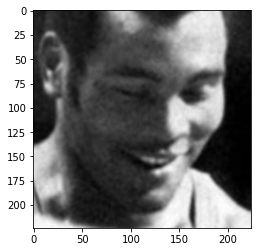

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/content/gdrive/.shortcut-targets-by-id/1Kv4V2PfcDb3WIGdtBo48x6lRiYbsR3GM/Biofacenet_n/DECA/DECA/decalib/utils/util.py:210: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  vertices_faces = vertices.reshape((bs * nv, 3))[faces.long()]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_c

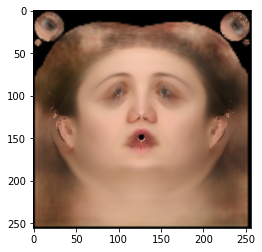

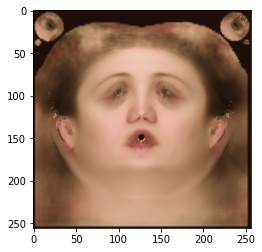

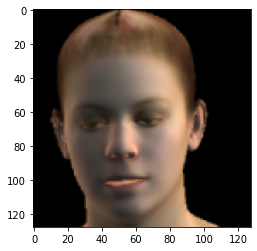

(2100, 128, 128, 3)
Africanm015pr162-FaceId-0_align_bidmc_01_syn.h5
1
random value 1.0342002033907691
Africanm015z4j62-FaceId-0_align


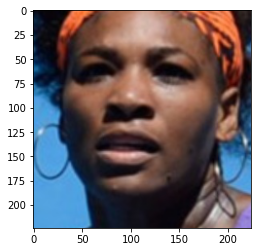

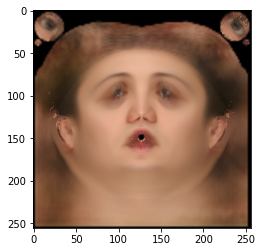

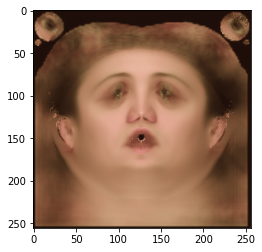

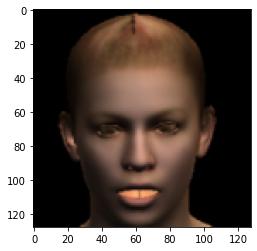

(2100, 128, 128, 3)
Africanm015z4j62-FaceId-0_align_bidmc_02_syn.h5
2
random value 1.0320727687016982
Africanm01kbx27-FaceId-1_align


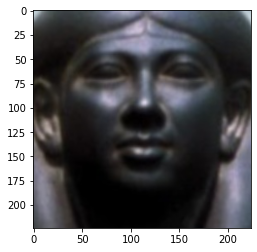

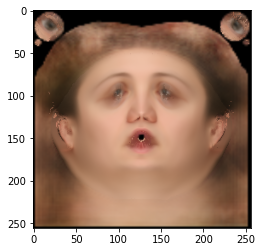

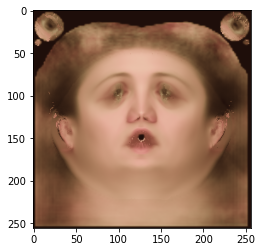

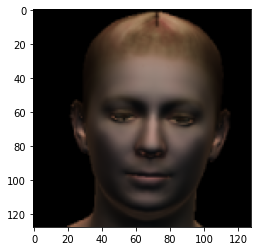

(2100, 128, 128, 3)
Africanm01kbx27-FaceId-1_align_bidmc_03_syn.h5
3
random value 0.9937102676854436
Africanm01l8wwt2-FaceId-0_align


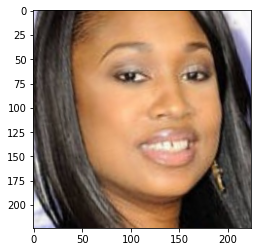

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


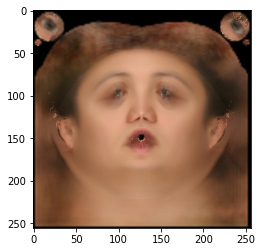

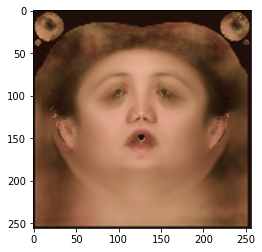

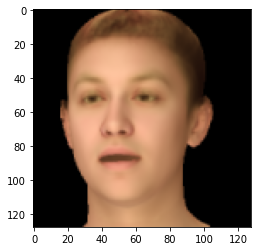

In [ ]:
m_aap =  nn.AdaptiveAvgPool2d((128, 128)) #use adaptive avg pooling to downsample image to 80x80
# m_upsample =  nn.AdaptiveAvgPool2d((256, 256))

with torch.no_grad():
  # load test images 
  testdata = datasets.TestData(args['inputpath'], iscrop=args['iscrop'], face_detector=args['detector'])
  expdata = datasets.TestData(args['exp_path'], iscrop=args['iscrop'], face_detector=args['detector'])
  
  for i in range(480): # last_time 120, 360 #453 172 
    try:
      # load image
      print(i)

      random_value = np.random.uniform(0.9, 1.1) 
      print('random value', random_value)

      cur_ppg_path = os.path.join(PPG_wave_dir, 'bidmc_' + "{:02d}".format(i%53+1) + '_Signals.csv')
      ppg_file = pd.read_csv(cur_ppg_path)
      target = ppg_file[' PLETH'].values
      target_rppg = []

      for rppg_index in range(params['num_generated_frames']):
        target_rppg.append(target[int(rppg_index / 30 * 125)])
      target = np.array(target_rppg)

      # lower_range = np.random.uniform(0.7, 0.95) 
      # upper_range = 2 - lower_range
      lower_range = params['lower_range']
      upper_range = params['upper_range']

      ratio_to_first_frame = (target - target[0]) / (np.max(target) - np.min(target)) # in the range [-1, 1]
      ratio_to_first_frame = lower_range + \
                          (ratio_to_first_frame - (-1))/2 * (upper_range - lower_range)
      ratio_to_first_frame = torch.from_numpy(ratio_to_first_frame).unsqueeze(1).unsqueeze(2).float().to(device)

      name = testdata[i]['imagename']
      print(name)
      images = testdata[i]['image'].to(device)[None,...]

      # Show image
      show_img(images.cpu()[0].permute(1, 2, 0).numpy())
      # show_img_final(images.cpu()[0].permute(1, 2, 0).numpy(), 'image.png')
      images = images.repeat(params['batch_size'], 1, 1, 1)
      # images = m_upsample(images)
      # DECA fit
      codedict = deca.encode(images)
      # print(codedict['light'].shape)
      opdict, visdict = deca.decode(codedict) #tensor
      albedo_uvmap = visdict['albedo']
      # show_img_final(albedo_uvmap.cpu()[0].permute(1, 2, 0).numpy(), 'albedo_uv.png')
      show_img(albedo_uvmap.cpu()[0].permute(1, 2, 0).numpy())
      
      # Prepare Biofacenet input
      albedo_uvmap_biofacenet = albedo_uvmap**2.2 - u.muim.view(-1,1,1)

      # albedo_uvmap_biofacenet = albedo_uvmap_biofacenet.repeat(64, 1, 1, 1)
      
      # Biofacenet fblood & fmel
      lightingparameters,b,fmel,fblood,predictedShading,specmask = model.predict(albedo_uvmap_biofacenet)
      weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,predictedShading,specmask = scalingNet(lightingparameters,b,fmel,fblood,predictedShading,specmask,u.bSize)
      
      

      # Generate pose
      #loading pose and expression from videos
      pose_data,exp_data = extract_pose_expression(pose_files[i])
      len_pose = pose_data.shape[0]
      fblood_first_frame = fblood

      target_pose = torch.from_numpy(pose_data[0,:,0:3]).to(device)
      for k in range(params['num_generated_frames'] - 1):
        new_pose = torch.from_numpy(pose_data[k%len_pose,:,0:3]).to(device)
        target_pose = torch.cat((target_pose, new_pose), 0)

      # Generate expression
      target_exp = torch.from_numpy(exp_data[0]).to(device)
      for k in range(params['num_generated_frames'] - 1):       
        new_exp = torch.from_numpy(exp_data[k%len_pose]).to(device)
        target_exp = torch.cat((target_exp, new_exp), 0)

      video_frame = []

      # fblood_original = fblood.clone()
      # fblood = fblood * uv_mask[:, 0, :, :] # rgb 3 dimensions for uv_mask

        # fmel = fmel * random_value
        # fmel = torch.clamp(fmel, -0.98, 0.98)


      for batch_num in range(target.shape[0]//params['batch_size']): #
        # Edit fblood & fmel TODO: Add PPG
      
        # fblood = fblood + 0.5
        fblood = fblood_first_frame[0].unsqueeze(0).repeat(params['batch_size'], 1, 1) \
                    * ratio_to_first_frame[batch_num*params['batch_size']:batch_num*params['batch_size'] + params['batch_size']].repeat(1, 256, 256)
        fblood = torch.clamp(fblood, -1, 1)

        # fblood[:, uv_mask[0, 0, :, :] == 0] = fblood_original[:, uv_mask[0, 0, :, :] == 0] # uv_mask dimension 1x3x256x256

        # Biofaceent reconstruct
        e = illuminationModel_modified(weightA,weightD,Fweights,CCT,u.illumA,u.illumDNorm,u.illumFNorm)
        Sr,Sg,Sb = cameraModel_modified(u.mu,u.PC,u.rgbCMF,b,u.wavelength)
        lightcolour = computelightcolour(e,Sr,Sg,Sb)
        Specularities = computeSpecularities(specmask,lightcolour)
        R_total = BiotoSpectralRef(fmel, fblood, u.Newskincolour)
        rawAppearance,diffuseAlbedo = ImageFormation(R_total, Sr,Sg,Sb,e,Specularities,predictedShading)
        ImwhiteBalanced = WhiteBalance(diffuseAlbedo,lightcolour)
        T_RAW2XYZ = findT(u.Tmatrix,BGrid)
        sRGBim = fromRawTosRGB(ImwhiteBalanced,T_RAW2XYZ,u.Txyzrgb)
        albedo_uvmap_modified = sRGBim**(1/2.2)

        # Show modified albedo
        if batch_num == 0:
          show_img(albedo_uvmap_modified.cpu()[0].permute(1, 2, 0).numpy())
        # show_img_final(albedo_uvmap_modified.cpu()[0].permute(1, 2, 0).numpy(), 'albedo_modified.png')

        # Edit pose

        codedict['pose'][:,:3] = target_pose[batch_num*params['batch_size']:batch_num*params['batch_size'] + params['batch_size'], :]
        codedict['cam'][:,:] = 0
        codedict['cam'][:,0] = 8

        # Edit expression
        codedict['exp'] = target_exp[batch_num*params['batch_size']:batch_num*params['batch_size'] + params['batch_size'], :]

        # DECA decode
        _, visdict_view = deca.decode_modified(codedict, albedo_uvmap_modified)
        reconstructed_img = m_aap(torch.clamp(visdict_view['rendered_images']*255, 0, 255))
        # reconstructed_img = m_aap(torch.clamp(visdict_view['shape_detail_images']*255, 0, 255))

        # shape_detail_image = torch.clamp(visdict_view['shape_detail_images']*255, 0, 255)  # * visdict_view['albedo_image']
        # show_img_final(shape_detail_image.cpu()[0].permute(1, 2, 0).numpy()/255, 'shape_detail.png')
        # # Show image
        if batch_num == 0:
          show_img(reconstructed_img.cpu()[0].permute(1, 2, 0).numpy()/255)
        # show_img(visdict_view['detail_normal_images'].cpu()[0].permute(1, 2, 0).numpy())

        if batch_num == 0:
          frame_saved = reconstructed_img.cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)       
        else:
          frame_saved = np.concatenate((frame_saved, reconstructed_img.cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)), 0)

      print(frame_saved.shape)
      # for i in range(frame_saved.shape[0]):
      #   show_img(frame_saved[i])
      new_h5_name = name + '_bidmc_' + "{:02d}".format(i%53+1) + '_syn.h5'
      hf = h5py.File(os.path.join(params['generated_video_path'], new_h5_name), 'w')
      hf.create_dataset('dataset_1', data=frame_saved)
      # hf.create_dataset('masks', data=original_masks)
      # hf.create_dataset('masks', data=original_mask_padded)
      hf.create_dataset('ppg', data=np.array(target))
      hf.close()
      print(new_h5_name)
    except:
        print('error')

# PPB

In [ ]:
m_aap =  nn.AdaptiveAvgPool2d((80, 80)) #use adaptive avg pooling to downsample image to 80x80
# m_upsample =  nn.AdaptiveAvgPool2d((256, 256))

with torch.no_grad():
  for fscale in range(6):
    # load test images 
    testdata = datasets.TestData(args['inputpath'] + '/F' + str(fscale+1), iscrop=args['iscrop'], face_detector=args['detector'])
    expdata = datasets.TestData(args['exp_path'], iscrop=args['iscrop'], face_detector=args['detector'])
    for i in range(65): # last_time 120, 360
      # load image
      print(i)

      cur_ppg_path = os.path.join(PPG_wave_dir, 'bidmc_' + "{:02d}".format(i%53+1) + '_Signals.csv')
      ppg_file = pd.read_csv(cur_ppg_path)
      target = ppg_file[' PLETH'].values
      target_rppg = []

      for rppg_index in range(params['num_generated_frames']):
        target_rppg.append(target[int(rppg_index / 30 * 125)])
      target = np.array(target_rppg)

      ratio_to_first_frame = (target - target[0]) / (np.max(target) - np.min(target)) # in the range [-1, 1]
      ratio_to_first_frame = params['lower_range'] + \
                          (ratio_to_first_frame - (-1))/2 * (params['upper_range'] - params['lower_range'])
      ratio_to_first_frame = torch.from_numpy(ratio_to_first_frame).unsqueeze(1).unsqueeze(2).float().to(device)

      name = testdata[i]['imagename']
      images = testdata[i]['image'].to(device)[None,...]

      # Show image
      show_img(images.cpu()[0].permute(1, 2, 0).numpy())
      # show_img_final(images.cpu()[0].permute(1, 2, 0).numpy(), 'image.png')
      images = images.repeat(params['batch_size'], 1, 1, 1)
      # images = m_upsample(images)
      # DECA fit
      codedict = deca.encode(images)
      # print(codedict['light'].shape)
      opdict, visdict = deca.decode(codedict) #tensor
      albedo_uvmap = visdict['albedo']
      # show_img_final(albedo_uvmap.cpu()[0].permute(1, 2, 0).numpy(), 'albedo_uv.png')
      
      # Prepare Biofacenet input
      albedo_uvmap_biofacenet = albedo_uvmap**2.2 - u.muim.view(-1,1,1)

      # albedo_uvmap_biofacenet = albedo_uvmap_biofacenet.repeat(64, 1, 1, 1)
      
      # Biofacenet fblood & fmel
      lightingparameters,b,fmel,fblood,predictedShading,specmask = model.predict(albedo_uvmap_biofacenet)
      # lightingparameters = lightingparameters.view(1, -1) # Add B dim
      # b = b.view(1, -1) # Add B dim
      weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,predictedShading,specmask = scalingNet(lightingparameters,b,fmel,fblood,predictedShading,specmask,u.bSize)
      
      
      # Show fmel & fblood
      # show_img(cm.jet(0.5*(1+fmel[0]).detach().cpu().numpy()))

      # show_img(cm.jet(0.5*(1+fblood[0]).detach().cpu().numpy()))
      # show_img_final(cm.jet(0.5*(1+fblood[5]).detach().cpu().numpy()), 'blood_map.png') 

      # Generate pose
      target_pose = 5 * torch.randn((1, 3))
      for k in range(params['num_generated_frames'] - 1):
        new_pose = target_pose[-1, :].view(1, 3) + torch.randn((1, 3))
        new_pose = torch.clamp(new_pose, -20, 20)
        target_pose = torch.cat((target_pose, new_pose), 0)

      # Generate expression
      target_exp = codedict['exp'][0:1]
      for k in range(params['num_generated_frames'] - 1):       
        # exp_images = expdata[i]['image'].to(device)[None,...]
        # exp_codedict = deca.encode(exp_images)
        # target_exp = torch.cat((target_exp, exp_codedict['exp']), 0)
        new_exp = target_exp[-1, :].view(1, 50) + 0.03 * torch.randn((1, 50)).cuda()
        target_exp = torch.cat((target_exp, new_exp), 0)

      video_frame = []

      fblood_original = fblood.clone()
      fblood = fblood * uv_mask[:, 0, :, :] # rgb 3 dimensions for uv_mask

      for batch_num in range(target.shape[0]//params['batch_size']): #
        # Edit fblood & fmel TODO: Add PPG
        # fmel = fmel + 0.05
        # fmel = torch.clamp(fmel, -1, 1)

        # fblood = fblood + 0.5
        fblood = fblood[0].unsqueeze(0).repeat(params['batch_size'], 1, 1) \
                    * ratio_to_first_frame[batch_num*params['batch_size']:batch_num*params['batch_size'] + params['batch_size']].repeat(1, 256, 256)
        fblood = torch.clamp(fblood, -1, 1)

        fblood[:, uv_mask[0, 0, :, :] == 0] = fblood_original[:, uv_mask[0, 0, :, :] == 0] # uv_mask dimension 1x3x256x256

        # Biofaceent reconstruct
        e = illuminationModel_modified(weightA,weightD,Fweights,CCT,u.illumA,u.illumDNorm,u.illumFNorm)
        Sr,Sg,Sb = cameraModel_modified(u.mu,u.PC,u.rgbCMF,b,u.wavelength)
        lightcolour = computelightcolour(e,Sr,Sg,Sb)
        Specularities = computeSpecularities(specmask,lightcolour)
        R_total = BiotoSpectralRef(fmel, fblood, u.Newskincolour)
        rawAppearance,diffuseAlbedo = ImageFormation(R_total, Sr,Sg,Sb,e,Specularities,predictedShading)
        ImwhiteBalanced = WhiteBalance(diffuseAlbedo,lightcolour)
        T_RAW2XYZ = findT(u.Tmatrix,BGrid)
        sRGBim = fromRawTosRGB(ImwhiteBalanced,T_RAW2XYZ,u.Txyzrgb)
        albedo_uvmap_modified = sRGBim**(1/2.2)

        # Show modified albedo
        # show_img(albedo_uvmap_modified.cpu()[0].permute(1, 2, 0).numpy())
        # show_img_final(albedo_uvmap_modified.cpu()[0].permute(1, 2, 0).numpy(), 'albedo_modified.png')

        # Edit pose
        euler_pose = target_pose[batch_num*params['batch_size']:batch_num*params['batch_size'] + params['batch_size'], :]
        # print(euler_pose)
        global_pose = batch_euler2axis(deg2rad(euler_pose[:, :3].cuda()))
        codedict['pose'][:,:3] = global_pose
        codedict['cam'][:,:] = 0
        codedict['cam'][:,0] = 8

        # Edit expression
        codedict['exp'] = target_exp[batch_num*params['batch_size']:batch_num*params['batch_size'] + params['batch_size'], :]
        # print(codedict['exp'])

        # DECA decode
        _, visdict_view = deca.decode_modified(codedict, albedo_uvmap_modified)
        # reconstructed_img = m_aap(torch.clamp(visdict_view['rendered_images']*255, 0, 255))
        reconstructed_img = m_aap(torch.clamp(visdict_view['shape_detail_images']*255, 0, 255))

        # shape_detail_image = torch.clamp(visdict_view['shape_detail_images']*255, 0, 255)  # * visdict_view['albedo_image']
        # show_img_final(shape_detail_image.cpu()[0].permute(1, 2, 0).numpy()/255, 'shape_detail.png')
        # # Show image
        # show_img(reconstructed_img.cpu()[0].permute(1, 2, 0).numpy()/255)
        # show_img(visdict_view['detail_normal_images'].cpu()[0].permute(1, 2, 0).numpy())

        if batch_num == 0:
          frame_saved = reconstructed_img.cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)       
        else:
          frame_saved = np.concatenate((frame_saved, reconstructed_img.cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)), 0)

      print(frame_saved.shape)
      # for i in range(frame_saved.shape[0]):
      #   show_img(frame_saved[i])
      new_h5_name = name + '_bidmc_' + "{:02d}".format(i%53+1) + '_syn.h5'
      hf = h5py.File(os.path.join(params['generated_video_path'], new_h5_name), 'w')
      hf.create_dataset('dataset_1', data=frame_saved)
      # hf.create_dataset('masks', data=original_masks)
      # hf.create_dataset('masks', data=original_mask_padded)
      hf.create_dataset('ppg', data=np.array(target))
      hf.close()
      print(new_h5_name)

# Debug, visualize target ppg wave 

In [ ]:
session_nums = [
    4 , 1, 9, 12, 13, 16, 18,
    26, 32, 33, 34, 35, 39, 40,
    44, 45, 47, 48, 25, 17, 27, 
    42, 5, 11, 15, 36, 38, 20, 41,
    43, 24, 8, 
    37, 3, 22, 31, 46, 
    14, 23, 30, 49, 10
    ]


PPG_wave_dir = '/content/gdrive/My Drive/Colorless Camera/ippg_generation/Bidmc_ppg_wave'
session_nums = np.arange(53)

session_nums = np.random.permutation(session_nums)
print(session_nums)

In [ ]:
cur_ppg_path = os.path.join(PPG_wave_dir, 'bidmc_' + "{:02d}".format(42) + '_Signals.csv')
ppg_file = pd.read_csv(cur_ppg_path)
target = ppg_file[' PLETH'].values
target.shape

In [ ]:
plt.plot(target)

In [ ]:
!cp ./../../UBFC_cropped_new.zip /content/UBFC_cropped_new.zip
!unzip /content/UBFC_cropped_new.zip -d /content

In [ ]:
root_dir = '/content/UBFC_cropped'

cur_video_path = os.path.join(root_dir, 'subject25.h5')
db = h5py.File(cur_video_path, 'r')

# frames = db['dataset_1']
target = db['ppg']
print(target.shape)

plt.plot(target[:500])

# Other

In [ ]:
torch.max(reconstructed_img)

In [ ]:
np.array(visdict_list).shape

In [ ]:
data=torch.from_numpy(np.array(visdict_list)).float()
torch.save(data,'./../celebAHQ_deca_albedo_2000_256.bin')

## Read h5 file 

In [5]:
from glob import glob
import random

pose_path = '/content/gdrive/.shortcut-targets-by-id/1Kv4V2PfcDb3WIGdtBo48x6lRiYbsR3GM/Biofacenet_n/FaceForensics/videos/original_sequences/youtube/raw/results'
pose_files = glob(pose_path + '/*.h5')
random.shuffle(pose_files)
print(len(pose_files))

917


In [6]:
print(pose_files[0])

/content/gdrive/.shortcut-targets-by-id/1Kv4V2PfcDb3WIGdtBo48x6lRiYbsR3GM/Biofacenet_n/FaceForensics/videos/original_sequences/youtube/raw/results/261_pose_exp_ytb.h5


In [ ]:
print()

In [10]:
import cv2
import os
import h5py
import numpy as np
def extract_pose_expression(filename):
    with h5py.File(filename, "r") as f:
        exp_key = list(f.keys())[0]
        exp_data = np.array(f[exp_key])
        pose_key = list(f.keys())[1]
        pose_data = np.array(f[pose_key])
    return pose_data,exp_data

In [11]:
pose_data,exp_data = extract_pose_expression(pose_files[0])

In [12]:
print(pose_data.shape,exp_data.shape)

(677, 1, 6) (677, 1, 50)
